# Text Analysis for Economists: Research Proposal
---

* Authors: Mathias Schindler, Kalliope Stassinos
<br>
* Institution: Universitat Pompeu Fabra
<br>
* Submission Date: June 30, 2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import json
import pickle
import networkx as nx
import operator

from datetime import datetime
from twarc_csv import DataFrameConverter
from twarc.expansions import ensure_flattened
from networkx.algorithms import community
from wordcloud import WordCloud
from nltk.tokenize import TreebankWordTokenizer, ToktokTokenizer, TweetTokenizer
from tqdm.notebook import tqdm
from termcolor import colored
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set()
sns.set_theme(context='paper',style='whitegrid')

/Users/mathiasschindler/opt/anaconda3/envs/thesis_pip/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.chdir('/Users/mathiasschindler/Library/Mobile Documents/com~apple~CloudDocs/BSE/_T3-Applied-Econ_(TxtM)/TermP_final')
# here use your path to current notebook

### Functions

In [3]:
def hash_retrieve(df):
    """
    df : dataframe of tweets
    Description: 
        The function takes as an object a df of tweets obtained via twarc and 
        returns a generator object.
    
    """

    for line, id in zip(df['entities.hashtags'], df['id']):
        if pd.isna(line):
            continue
        line = line.strip()
        data = json.loads(line)
        for hashtag in ensure_flattened(data):
            yield [hashtag['tag'], id]

In [4]:
def remove_encoding_word(word):
    word = str(word)
    word = word.encode('ASCII', 'ignore').decode('ASCII')
    return word

In [5]:
def remove_encoding_text(text):
    text = str(text)
    text = ' '.join(remove_encoding_word(word) for word in text.split() if word not in stop)
    return text

In [6]:
def tokenize(document):
    #tokens = [lemma(w) for w in document.split() if len(w) > 3 and w.isalpha()]
    tokens = [w for w in document.split() if len(w) > 3 and w.isalpha()]
    return tokens

In [7]:
def f_affiliation(DF,Affiliation="Unlabeled"):
    '''
    Objective: Receive a affiliation (Left, Right or Unlabeled) and return a DataFrame only with the tweets from authors of this affiliation.

    Date: June 10, 2022
    '''
    
    df_1=DF.copy()
    df_1['Label']=df_1['Label'].fillna("Unlabeled")
    return df_1[df_1['Label']==Affiliation]

In [8]:
def pday_tweets(DF: pd.DataFrame):
    '''
    Objective: Plot the number of tweets per day

    Date: June 3, 2022
    '''
    df_1=DF.copy()
    df_1['created_at']=df_1['created_at'].astype(str)
    df_1['Date'] = df_1['created_at'].str[0:10]
    df_1['Date'] = pd.to_datetime(df_1['Date']).dt.date

    tweets_per_day = df_1.groupby(['Date']).count()
    tweets_per_day['day'] = tweets_per_day.index
    
    plt.figure(figsize = (20, 10))
    plt.plot(tweets_per_day['day'], tweets_per_day['id'])
    plt.title('Tweets Per Day', fontsize = 18)
    plt.ylabel('Tweets Count', fontsize = 18)
    plt.xticks(rotation = 90, fontsize = 18)
    plt.yticks(fontsize = 18);

In [9]:
def word_cloud(DF: pd.DataFrame, number_of_words = 100):
    '''
    Objective: Plot a word cloud of the data set
    Date: June 3, 2022
    '''
    df_1=DF.copy()
    df_1['cleaned_text']=df_1['cleaned_text'].fillna(str(""))
    string = " ".join(list(df_1['cleaned_text']))
    wordcloud = WordCloud(max_font_size = 100, max_words = number_of_words, background_color = "white",min_font_size = 10,width = 1600,height = 800).generate(string)
    plt.figure(figsize = (20, 10))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")

In [10]:
def word_cloud_tfidf(DF:pd.DataFrame, ngram_start = 1, ngram_end = 1):
    text = ' '.join(words for words in DF['cleaned_text'])
    vectorizer = TfidfVectorizer(tokenizer = tokenize, 
                                 ngram_range = ((ngram_start,ngram_end)),  
                                 strip_accents = 'unicode')
    tdm = vectorizer.fit_transform(DF['cleaned_text'])
    tfidf_weights = [(word, tdm.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
    tfidf_dict = dict(tfidf_weights)
    
    w = WordCloud(width=1500, height=1200, 
              mode='RGBA', background_color='white', 
              max_words=100).fit_words(tfidf_dict)
    plt.figure(figsize=(20, 10))
    plt.imshow(w)
    plt.axis('off')

In [11]:
def top_hashtags(DF: pd.DataFrame,number_print=100,number_plot=20, title = ' ') -> list:
    '''
    Objective: Print the common hashtags and plot how often are used each one.
    Date: June 3, 2022
    '''
    df_1=DF.copy()
    hasht=[]
    for i in df_1.index:
        try:
            hasht.append(df_1['tweet_hashtags'][i].split(","))
        except:
            hasht.append([])

    df_1['list_hashtags']=hasht
    hashtags=[]
    for ix in df_1.index:
        hashtags+=df_1['list_hashtags'][ix]
    #print("There are {} different hashtags.".format(len(list(set(hashtags)))))
    #print('\n')
    count = Counter(hashtags)
    most_occur = count.most_common(number_print)
    #print(most_occur)
    
    data = most_occur[0:number_plot]

    n_groups = len(data)

    vals = [x[1] for x in data]
    legends = [x[0] for x in data]
    legends = ['#'+x for x in legends]

    index = np.arange(n_groups)
    bar_width = 0.25
    plt.figure(figsize = (20, 10))
    rects1 = plt.bar(index, vals, bar_width,
                     color='b',
                     label='Ocurrences')

    plt.ylabel('Count (Hashtags)', fontsize=22)
    plt.title('Top Hashtags', fontsize=18)
    plt.xticks(index, legends, fontsize = 22)
    plt.xticks(rotation = 90)
    plt.yticks(fontsize = 22)
    plt.title(title, fontsize = 24)
    plt.tight_layout()

In [12]:
def top_bigrams(DF:pd.DataFrame,number_of_bigrams=100,number_plot=20, title = "", split_bi = False):
    df_1=DF.copy()
    df_1['cleaned_text']=df_1['cleaned_text'].fillna("")
    string=" ".join(list(df_1['cleaned_text']))
    split_it = string.split()
    bigrams = zip(split_it, split_it[1:])
    counts = Counter(bigrams)
    most_occur = counts.most_common(number_of_bigrams)
    #print(most_occur)
    
    data = most_occur[0:number_plot]

    n_groups = len(data)

    vals = [x[1] for x in data]
    legends = [x[0] for x in data]
    if split_bi == True:
        legends = [str(x) for x in legends]
        legends = [x.replace("(", "") for x in legends]
        legends = [x.replace(")", "") for x in legends]
        legends = [x.replace("', '", "', \n'") for x in legends]


    index = np.arange(n_groups)
    bar_width = 0.25
    plt.figure(figsize = (20, 10))
    rects1 = plt.bar(index, vals, bar_width,
                     color='b',
                     label='Ocurrences')


   
    
    plt.xlabel('Bigrams', fontsize=18)
    plt.ylabel('Count (Bigrams)', fontsize=22)
    plt.title('Top Bigrams', fontsize=18)
    plt.xticks(index, legends, fontsize = 22)
    plt.xticks(rotation = 90)
    plt.yticks(fontsize = 22)
    plt.title(title, fontsize = 24)
    plt.tight_layout()

In [13]:
def compare_word_pday (DF,list_of_words,standardized=True):
    '''
    Objective: Print how many tweets (or the percentage per day) use words from a list.
    Date: June 10, 2022
    '''
    
    df_1=DF.copy()
    df_1['created_at']=df_1['created_at'].astype(str)
    df_right=df_1[df_1['Label']=="Right"]
    df_left=df_1[df_1['Label']=="Left"]
    for word in list_of_words:
        regex = '(?:^|\W)'+word+'(?:$|\W)'
        df_word_right= df_right.dropna(subset=['cleaned_text']).copy()
        df_word_left=df_left.dropna(subset=['cleaned_text']).copy()

        df_word_right=df_word_right[df_word_right.cleaned_text.str.contains(regex)]
        df_word_left=df_word_left[df_word_left.cleaned_text.str.contains(regex)]
        
        df_word_right['count_'+str(word)]=1
        df_word_left['count_'+str(word)]=1
        
        df_right=df_right.merge(df_word_right[['id','count_'+str(word)]],how="left",on="id")
        df_left=df_left.merge(df_word_left[['id','count_'+str(word)]],how="left",on="id")
    
    df_right['total']=0
    df_left['total']=0
    
    title=str("")
    for word in list_of_words:
        df_right['count_'+str(word)]=df_right['count_'+str(word)].fillna(0)
        df_left['count_'+str(word)]=df_left['count_'+str(word)].fillna(0)
        
        df_right['total']+=df_right['count_'+str(word)]
        df_left['total']+=df_left['count_'+str(word)]
        title+=word+ " or "
        
    title=title[:-4]
    
    df_right['contains']=np.where(df_right.total>0,1,0)
    df_left['contains']=np.where(df_left.total>0,1,0)
           
        
    df_right['Date']=df_right['created_at'].str[0:10]
    df_left['Date']=df_left['created_at'].str[0:10]
    df_right['Date']=pd.to_datetime(df_right['Date']).dt.date
    df_left['Date']=pd.to_datetime(df_right['Date']).dt.date
    right_per_day=df_right.groupby(['Date']).sum()
    left_per_day=df_left.groupby(['Date']).sum()
    
    
    if standardized==False:
        fig, ax = plt.subplots(figsize=(18,8))
        ax.plot(right_per_day['contains'], label="Right frequency");
        ax.plot(left_per_day['contains'], label="Left frequency");
        ax.legend(loc='upper left');
        ax.set_title('Total Frequency of tweets that contains '+ title);
    
    if standardized==True:
        #Compute the total amount of tweets per day per affiliation to divide for it.
        total_right=df_right[['id','Date']].groupby(['Date']).count()
        total_left=df_left[['id','Date']].groupby(['Date']).count()
        total_right.rename(columns = {'id':'all_tweets'}, inplace = True)
        total_left.rename(columns = {'id':'all_tweets'}, inplace = True)
        right_per_day=right_per_day.join(total_right)
        left_per_day=left_per_day.join(total_left)
        
        right_per_day['proportion']=right_per_day['contains']/right_per_day['all_tweets']
        left_per_day['proportion']=left_per_day['contains']/left_per_day['all_tweets']
        
        fig, ax = plt.subplots(figsize=(18,8))
        ax.plot(right_per_day['proportion'], label="Right-Leaning Users");
        ax.plot(left_per_day['proportion'], label="Left-Leaning Users");
        ax.set_ylabel('Proportion', fontsize = 20.0) # Y label
        ax.tick_params(axis = "x", labelsize = 18);
        ax.tick_params(axis = "y", labelsize = 18);
        ax.legend(loc = 'upper left', fontsize = 18);

# Load Data

In [14]:
file ='hashtags_left_rigth.sav'
df = pickle.load(open(file, 'rb'))

In [15]:
df.shape

(2133185, 6)

In [16]:
df.head()

,Unnamed: 0,id,text,author.id,author.username,entities.hashtags
0,0,1472718116954284034,Gracias a todos quienes confiaron en este proy...,1470863310497234952,GiuliaSparza,"[{""start"": 133, ""end"": 156, ""tag"": ""BoricPresi..."
1,1,1472717379323019269,"«Sigan ustedes sabiendo que, mucho más tempran...",1470863310497234952,GiuliaSparza,"[{""start"": 159, ""end"": 182, ""tag"": ""BoricPresi..."
2,2,1472717250104741892,“Espero q lo hagamos mejor”\n\nUna imagen hist...,1339781999779786760,raw_sie,"[{""start"": 247, ""end"": 270, ""tag"": ""BoricPresi..."
3,3,1472717213786386433,Y el pueblo está feliz!! #Arica #BoricPresiden...,1470863310497234952,GiuliaSparza,"[{""start"": 25, ""end"": 31, ""tag"": ""Arica""}, {""s..."
4,4,1472716838765314053,"Feliz! Por más ciencia, por más medio ambiente...",1470863310497234952,GiuliaSparza,"[{""start"": 107, ""end"": 127, ""tag"": ""BoricPresi..."


# Label Users

In [17]:
right_hashtags=["atreveteconkast", "kastpresidente2022", "kastpresidente","vota2votakast", "atreveteporchile", 
                "sepuede", "todochileconkast", "kastledaesperanzaachile", "chilevotakast", "atrevidos", 
                "consichelsepuede", "sichelpresidente", "atrevidosporkast", "votakast","mujeresporkast"]

In [18]:
left_hashtags=["boricpresidente","seguimos", "boricpresidentedechile", "apruebodignidad", "rutaesperanzaxboric", 
               "boricnosune", "boricpresidente2022", "unmillondepuertasxboric", "1millondepuertasxboric", 
               "meunoconboric", "ahorayasna", "boricpresidentedechile2022", "boricenprimeravuelta", "vota1", 
               "paravivirmejor"]

In [19]:
authors=list(df['author.username'])
authors = list(set(authors))
print(len(authors))

28310


In [20]:
start = datetime.now() #Start timer

hashtags_df = pd.DataFrame(list(hash_retrieve(df)),
                 columns=['tweet_hashtags', 'id'])

hashtags_df = hashtags_df.groupby('id')['tweet_hashtags'].apply(lambda x: ','.join(x))
df = df.merge(hashtags_df, how='left', left_on='id', right_on='id')
df['tweet_hashtags']=df['tweet_hashtags'].str.lower()

hasht=[]
for i in df.index:
    try:
        hasht.append(df['tweet_hashtags'][i].split(","))
    except:
        hasht.append([])
    
    
df['list_hashtags']=hasht

hashtags=[]
for i in df.index:
    hashtags+=list(df['list_hashtags'][i])
    
print('Runtime:', datetime.now() - start) #Print runtime

Runtime: 0:01:30.458929


In [21]:
# For each left hashtags we put a 1 to each tweet that use this hashtag
for hashtag in left_hashtags:
    df_hash=pd.DataFrame()
    df_hash=df.dropna(subset=['tweet_hashtags']).copy()
    df_hash=df_hash[df_hash.tweet_hashtags.str.contains(hashtag)]
    df_hash['count_left_'+str(hashtag)]=1
    df=df.merge(df_hash[['id','count_left_'+str(hashtag)]],how="left",on="id")

In [22]:
# We sum for all the hashtags.
df['count_left']=0
for hashtag in left_hashtags:
    try:
        df[['count_left_'+str(hashtag)]]=df[['count_left_'+str(hashtag)]].fillna(0)
        df['count_left']+=df['count_left_'+str(hashtag)]
    except:
        print("No use of hashtag: " + hashtag)

In [23]:
# Doing the same for right hashtags
for hashtag in right_hashtags:
    df_hash=pd.DataFrame()
    df_hash=df.dropna(subset=['tweet_hashtags']).copy()
    df_hash=df_hash[df_hash.tweet_hashtags.str.contains(hashtag)]
    df_hash['count_right_'+str(hashtag)]=1
    df=df.merge(df_hash[['id','count_right_'+str(hashtag)]],how="left",on="id")

In [24]:
start = datetime.now() #Start timer

df['count_right']=0
for hashtag in right_hashtags:
    try:
        df[['count_right_'+str(hashtag)]]=df[['count_right_'+str(hashtag)]].fillna(0)
        df['count_right']+=df['count_right_'+str(hashtag)]
    except:
        print("No use of hashtag: " + hashtag)
        
print('Runtime:', datetime.now() - start) #Print runtime

Runtime: 0:00:18.726218


In [25]:
# Now we group by author, to know all the hashtags that each user used.
hashtags_per_author=df[['author.username','count_right','count_left']].groupby('author.username').sum()

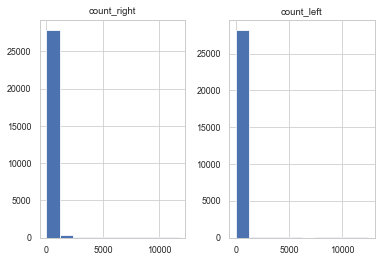

In [26]:
hashtags_per_author.hist();

In [27]:
# We compute the % of right and left hashtags per user
hashtags_per_author['percentage_right'] = hashtags_per_author['count_right'].astype(float)/(hashtags_per_author['count_right'].astype(float) 
                                                                                          + hashtags_per_author['count_left'].astype(float))
hashtags_per_author['percentage_left'] = hashtags_per_author['count_left'].astype(float)/(hashtags_per_author['count_right'].astype(float) 
                                                                                        + hashtags_per_author['count_left'].astype(float))

In [28]:
number_threshold=40
proportion_threshold=0.8

In [29]:
hashtags_per_author['Label']="None"
hashtags_per_author['Label'][(hashtags_per_author.percentage_right > proportion_threshold) 
                             & (hashtags_per_author.count_right > number_threshold)]="Right"
hashtags_per_author['Label'][(hashtags_per_author.percentage_left > proportion_threshold) 
                             & (hashtags_per_author.count_left > number_threshold)]="Left"

/var/folders/38/pqdkmnzn27z4y7tybr0ccrnc0000gn/T/ipykernel_92575/2370969891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hashtags_per_author['Label'][(hashtags_per_author.percentage_right > proportion_threshold)
/var/folders/38/pqdkmnzn27z4y7tybr0ccrnc0000gn/T/ipykernel_92575/2370969891.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hashtags_per_author['Label'][(hashtags_per_author.percentage_left > proportion_threshold)


In [30]:
hashtags_per_author['Label'].value_counts()

None     17907
Right     5416
Left      4987
Name: Label, dtype: int64

In [31]:
file ='final_data_set_without_label.sav'
df_immigration = pickle.load(open(file, 'rb'))

In [32]:
# Here we merge to put labels in the immigration data set 
df_final = df_immigration.merge(hashtags_per_author[["Label"]],
                    how = "left",
                    on = "author.username")

In [33]:
df_final['Label'] = df_final['Label'].fillna("Unlabeled")

In [34]:
df_final.shape

(573999, 20)

In [35]:
df_final['cleaned_text'] = df_final['cleaned_text'].fillna("")

In [36]:
df_final.head()

,id,text,conversation_id,author.id,author.description,author.location,author.username,author.name,entities.hashtags,author.public_metrics.followers_count,author.verified,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,cleaned_text,tweet_hashtags,created_at,list_hashtags,Label
0,1513295387230019585,@itajuschile Déjate de inventar weas!!! Tu sab...,1512966960723595268,119939347,NaN,Chile,Pao_cc,Pao,NaN,104,False,1,0,0,0,@itajuschile dejate inventar weas sabias udi p...,NaN,2022-04-10T23:18:30.000Z,[],Unlabeled
1,1508093581508034569,Y siguen llegando migrantes irregulares a #Iqu...,1508093581508034569,1498451030014582787,Humano antes que todo... :),"Iquique, Chile",cesarmateoparr,César Mateo,"[{""start"": 42, ""end"": 50, ""tag"": ""Iquique""}, {...",262,False,5,0,2,4,siguen llegando migrantes irregulares #iquique...,"iquique,tarapacá",2022-03-27T14:48:23.000Z,"[iquique, tarapacá]",Unlabeled
2,1507517350899175428,@JavierOlivares @GobiernodeChile Así es! Lasti...,1507148876775522318,1498451030014582787,Humano antes que todo... :),"Iquique, Chile",cesarmateoparr,César Mateo,"[{""start"": 59, ""end"": 67, ""tag"": ""Merluzo""}, {...",262,False,0,0,0,0,@javierolivares @gobiernodechile asi lastimosa...,"merluzo,bellaco,chile,inflacion",2022-03-26T00:38:39.000Z,"[merluzo, bellaco, chile, inflacion]",Unlabeled
3,1507024573354631168,Les comienzan a detener! Falta una ley que le...,1507024573354631168,1498451030014582787,Humano antes que todo... :),"Iquique, Chile",cesarmateoparr,César Mateo,"[{""start"": 226, ""end"": 239, ""tag"": ""AltoHospic...",262,False,1,0,1,1,comienzan detener falta ley obligue pagar trab...,"altohospicio,iquique",2022-03-24T16:00:32.000Z,"[altohospicio, iquique]",Unlabeled
4,1505958342153293826,@Fernand25825606 @mmlagoscc Y no es webeo. Me...,1505892865741840392,1141471245185273868,Paz en el mundo \n\n🕊🕊,"Valparaíso, Chile",CarlosA17037514,EL FENÓMENO,NaN,219,False,1,0,1,0,@fernand @mmlagoscc webeo menos mal bolivianos...,NaN,2022-03-21T17:23:42.000Z,[],Right


# Table 1

In [37]:
_ = df_final
print('Total Corpus')
print('Total Tweets:', len(_))
print('Unique Authors:', len(list(set(list(_['author.username'])))))
print('Unique Words:', len(set(" ".join(list(_['cleaned_text'])).split(' '))))
print('Unique Hashtags:', len(set([element for list_ in _['list_hashtags'] for element in list_])))

Total Corpus
Total Tweets: 573999
Unique Authors: 45525
Unique Words: 346601
Unique Hashtags: 24266


In [38]:
_ = f_affiliation(df_final, 'Left')
print('Left-Leaning Sub-Corpus')
print('Total Tweets:', len(_))
print('Unique Authors:', len(list(set(list(_['author.username'])))))
print('Unique Words:', len(set(" ".join(list(_['cleaned_text'])).split(' '))))
print('Unique Hashtags:', len(set([element for list_ in _['list_hashtags'] for element in list_])))

Left-Leaning Sub-Corpus
Total Tweets: 59153
Unique Authors: 4530
Unique Words: 83510
Unique Hashtags: 4266


In [39]:
_ = f_affiliation(df_final, 'Right')
print('Right-Leaning Sub-Corpus')
print('Total Tweets:', len(_))
print('Unique Authors:', len(list(set(list(_['author.username'])))))
print('Unique Words:', len(set(" ".join(list(_['cleaned_text'])).split(' '))))
print('Unique Hashtags:', len(set([element for list_ in _['list_hashtags'] for element in list_])))

Right-Leaning Sub-Corpus
Total Tweets: 157164
Unique Authors: 5082
Unique Words: 140325
Unique Hashtags: 7821


# Figure 1

## 1a

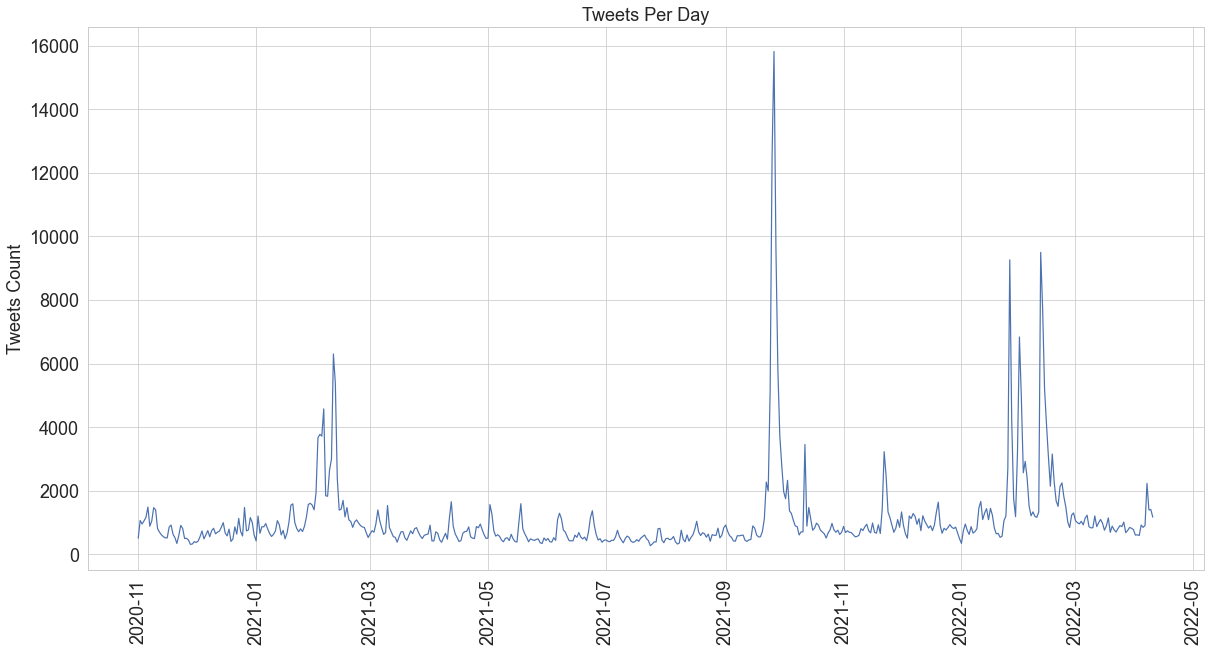

In [40]:
pday_tweets(df_final)
plt.savefig('figs/fig1a.png', bbox_inches='tight')

## 1b

Runtime: 0:00:54.349790


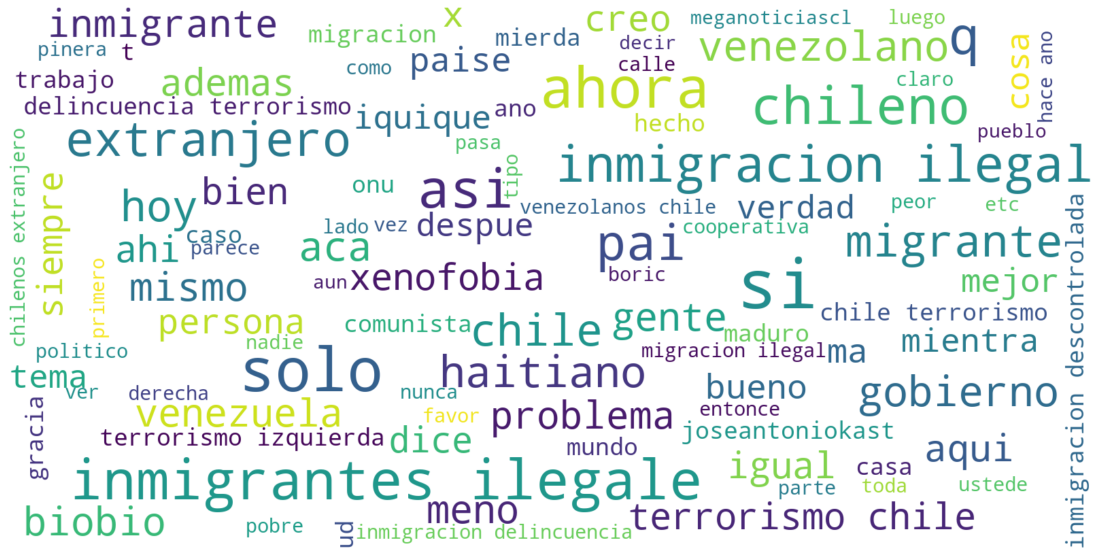

In [41]:
start = datetime.now() #Start timer

word_cloud(df_final)
plt.savefig('figs/fig1b.png', bbox_inches='tight')

print('Runtime:', datetime.now() - start) #Print runtime

## 1b - `tf-idf`

Running the `tf-idf`-weighted corpus in a word cloud is too slow so here it is done on a 10 pct. random sample for demonstration purposes.

In [42]:
df_test = df_final.sample(frac = 0.10)

Runtime: 0:03:24.429438


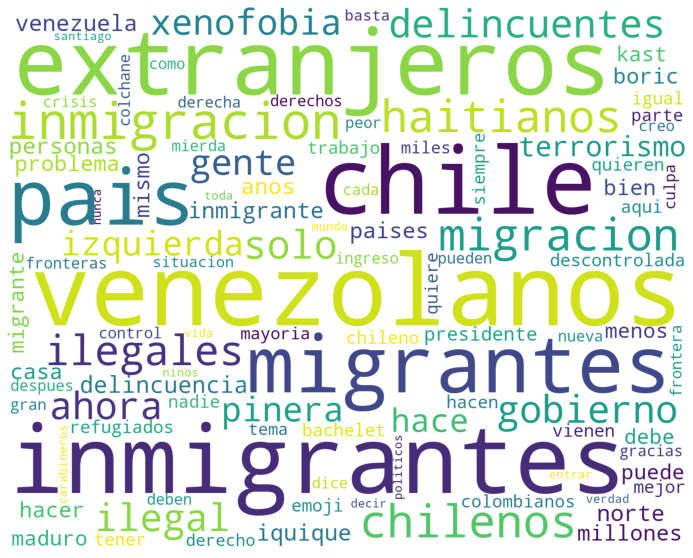

In [43]:
start = datetime.now() #Start timer

word_cloud_tfidf(df_test, 1, 1)
plt.savefig('figs/fig1b_tfidf.png', bbox_inches='tight')

print('Runtime:', datetime.now() - start) #Print runtime

## 1c

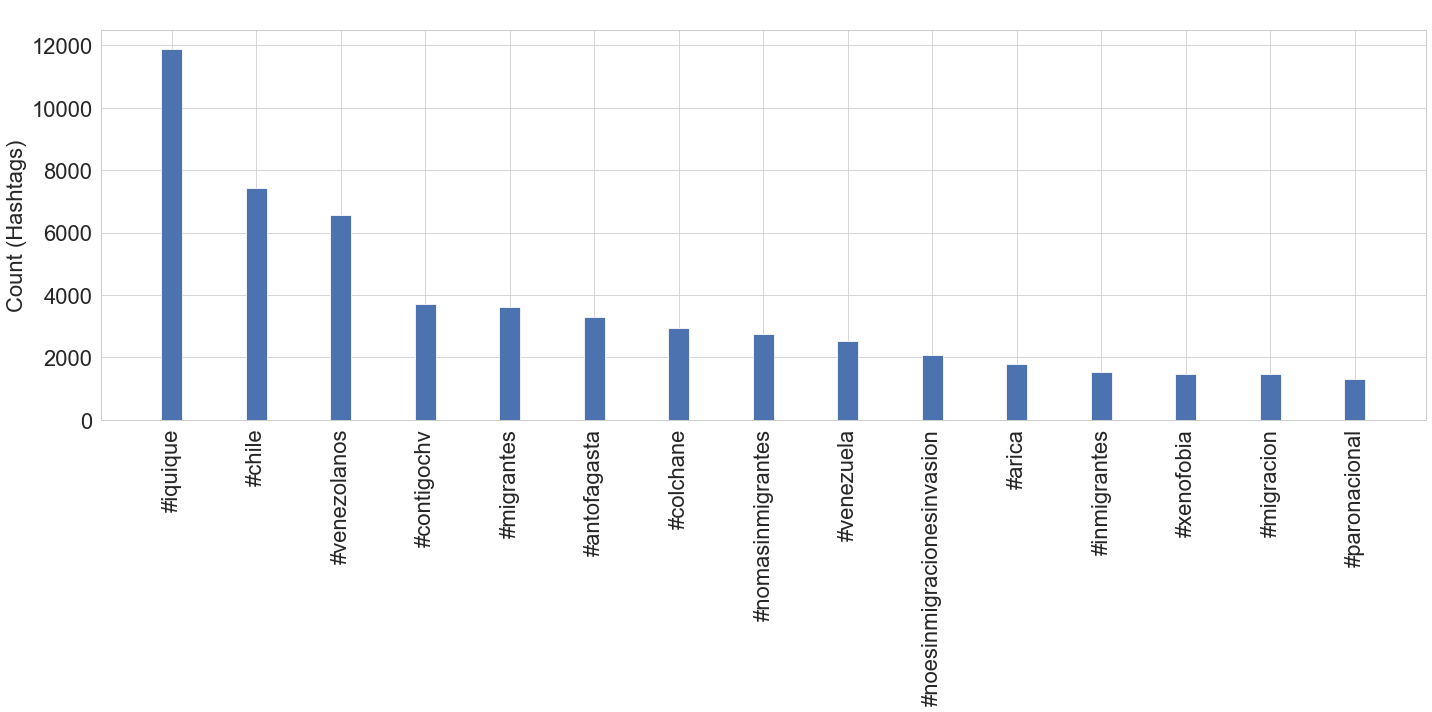

In [44]:
top_hashtags(df_final,15,15," ")
plt.savefig('figs/fig1c.png', bbox_inches='tight')

## 1d

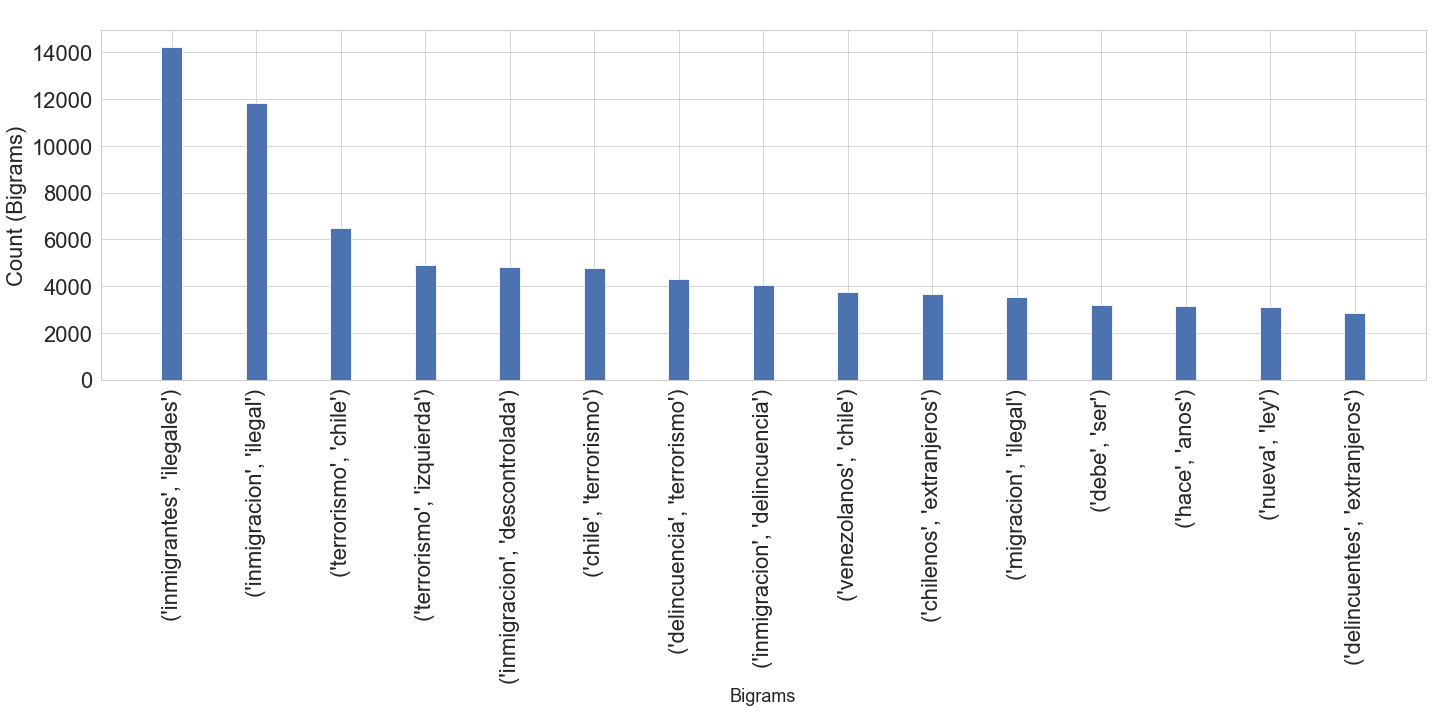

In [45]:
top_bigrams(df_final,15,15," ")
plt.savefig('figs/fig1d.png', bbox_inches='tight')

# Figure 2

## 2a

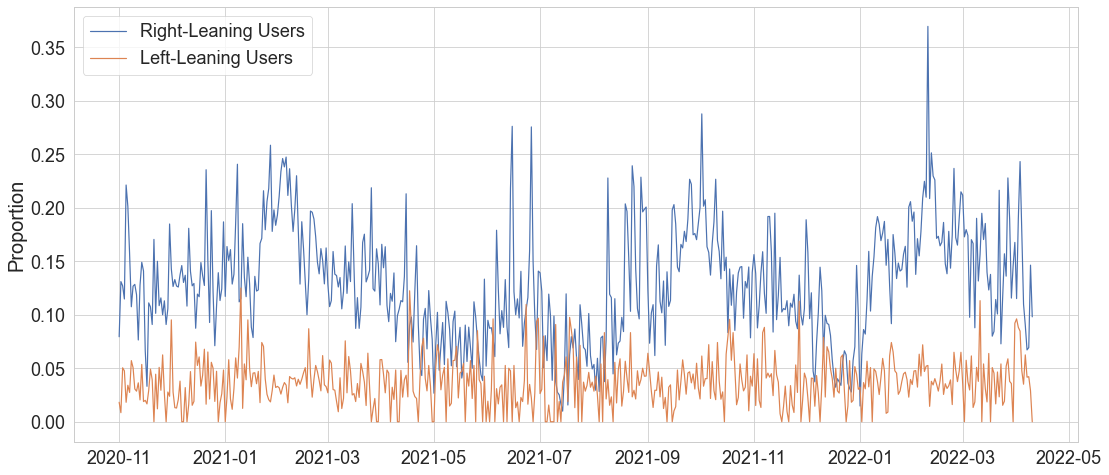

In [46]:
terms = ['ilegal','ilegales','indocumentado','indocumentados']
compare_word_pday(df_final, terms)
plt.savefig('figs/fig2a.png', bbox_inches='tight')

## 2b

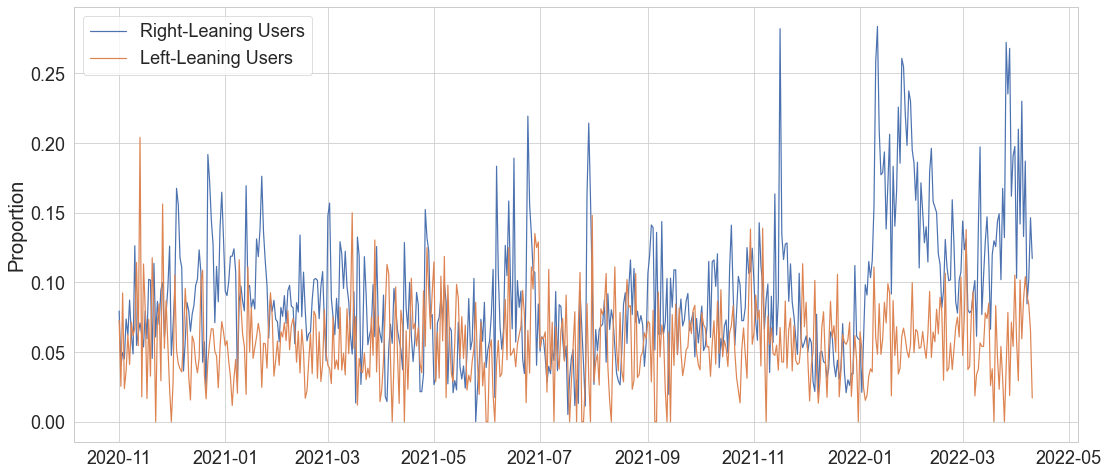

In [47]:
terms = ['delincuentes','delincuencia','crimen','criminiales','delito','delitos','robo','ladron','ladrones']
compare_word_pday(df_final,terms)
plt.savefig('figs/fig2b.png', bbox_inches='tight')

## 2c

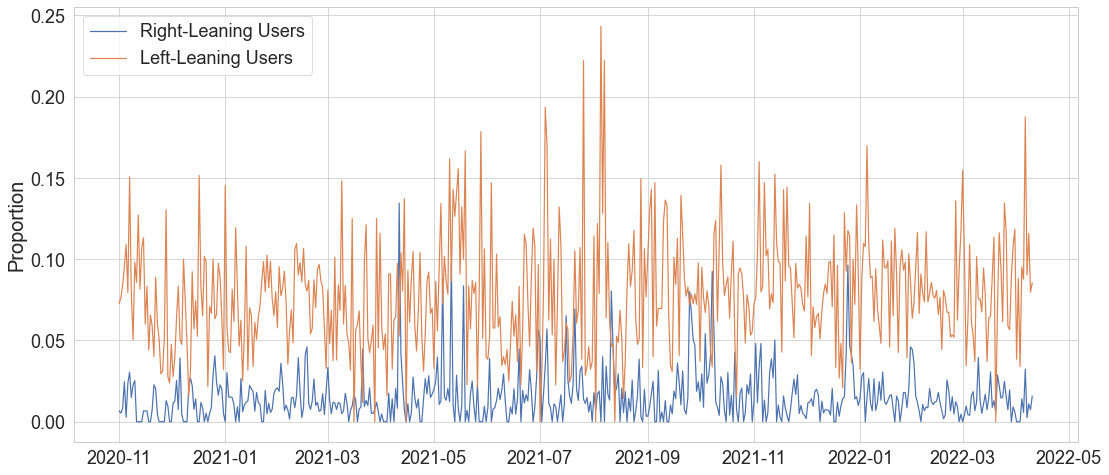

In [48]:
terms = ['xenofobia','racismo','discriminacion','discriminados']
compare_word_pday(df_final,terms)
plt.savefig('figs/fig2c.png', bbox_inches='tight')

# Figure 3

In [49]:
start = datetime.now() #Start timer

In [50]:
edges=pd.read_csv("network_data/network_final.csv",header=None)

In [51]:
edges.columns=['retweeted_by','original_author','weight','rts']
edges['len']=edges['weight'].str.len()

edges_1=edges[edges.len==12] #define the number of the retweetsts digits
edges_2=edges[edges.len==13]
edges_3=edges[edges.len==14]
edges_4=edges[edges.len==15]

dfs=[edges_1,edges_2,edges_3,edges_4] #extract all , depending on the digits
numb=[-1,-2,-3,-4]
for df,i in zip(dfs,numb):
    weights=df['weight'].str[i:]
    df['weight']=weights
    df['weight']=df['weight'].astype(int)

edges=pd.concat([edges_1,edges_2,edges_3,edges_4])
edges=edges.drop(['rts','len'],axis=1)

edges=edges[edges.retweeted_by!=edges.original_author]

filename = 'network_data/data_frame_edges.sav'
pickle.dump((edges), open(filename, 'wb'))

/var/folders/38/pqdkmnzn27z4y7tybr0ccrnc0000gn/T/ipykernel_92575/1959411439.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight']=weights
/var/folders/38/pqdkmnzn27z4y7tybr0ccrnc0000gn/T/ipykernel_92575/1959411439.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight']=df['weight'].astype(int)


In [52]:
all_tweets=pd.read_csv("network_data/final_cleaned_data_set.csv")

In [53]:
authors=list(all_tweets['author.username'])
authors=list(set(authors))

In [54]:
labels=pd.read_csv('network_data/Labeled_Users_Left_Right.csv')

In [55]:
authors_with_label=pd.DataFrame()
authors_with_label['author.username']=authors
authors_with_label=authors_with_label.merge(labels[['author.username','Label']],on='author.username',how='left')
authors_with_label['Label']=authors_with_label['Label'].fillna("Unlabeled")
authors_with_label['Label'].value_counts()

Unlabeled    35919
Right         5076
Left          4530
Name: Label, dtype: int64

In [56]:
file = 'network_data/data_frame_edges.sav'
edges = pickle.load(open(file, 'rb'))

In [57]:
file = 'network_data/complete_network.sav'
total_G = pickle.load(open(file, 'rb'))

In [58]:
G=total_G.copy() #save and work on the copy for the first analysis
G_un=G.to_undirected() #create an undirected version of network for some measures
lab_copy=authors_with_label.copy()#save the label data for label spreading : Not implemented for directed graphs

In [59]:
print(nx.info(G))
print("Network density:", nx.density(G))

DiGraph with 45525 nodes and 578383 edges
Network density: 0.00027907770984146


/var/folders/38/pqdkmnzn27z4y7tybr0ccrnc0000gn/T/ipykernel_92575/1754243506.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [60]:
#general metrics
degree_dict = dict(G.degree(G.nodes())) #degree 
nx.set_node_attributes(G, degree_dict, 'degree')

degree_dict_in = dict(G.in_degree(G.nodes())) #in degree
nx.set_node_attributes(G, degree_dict_in, 'degree_in')

degree_dict_out = dict(G.out_degree(G.nodes())) #out degree
nx.set_node_attributes(G, degree_dict_out, 'degree_out')

eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

degree_dict = nx.degree_centrality(G) # Run degree centrality
nx.set_node_attributes(G, degree_dict, 'degree_cent')

In [61]:
#Create degree centrality df (influencial retweets)
d=pd.DataFrame.from_dict(degree_dict, orient='index').reset_index()
d.columns=['author.username', 'degree_cent']
d=pd.merge(d,lab_copy, on="author.username", how="inner")
d.columns=['User', 'Retweet influence : Degree centrality', 'Label']
d=d.sort_values("Retweet influence : Degree centrality",ascending=False).reset_index()

In [62]:
#choose some max number of users for analysis and graph
top=1000

In [63]:
#filter left and right
left=d[d["Label"]=='Left'] 
right=d[d["Label"]=='Right']

top_left=left.iloc[0:top]
top_right=right.iloc[0:top]
top_all=d.iloc[0:top]

In [64]:
#choose the df of interest (all or left or righ nodes)
subset_influencial=top_all.copy()

Plot the network:

In [65]:
#plot param
plt.rcParams['figure.figsize'] = [15, 10]

In [66]:
colors = {'Right':'orange','Left':'limegreen','Unlabeled':'fuchsia'} #assign colours to labels
subset_influencial['Colours'] = subset_influencial['Label'].apply(lambda x: colors[x]) #apply colours to labels in df
listofnodes=list(subset_influencial['User'])  #create a list of authors

In [67]:
most_influencialG=G_un.subgraph(listofnodes) #create a subgraph with undirected G and the nodes of interest
pos_nodes = nx.spring_layout(most_influencialG) #save the position of nodes (for colouring and legend)

subset_influencial.set_index(subset_influencial['User'], inplace=True)
listofcolours=subset_influencial.loc[list(nx.spring_layout(most_influencialG).keys()), 'Colours']

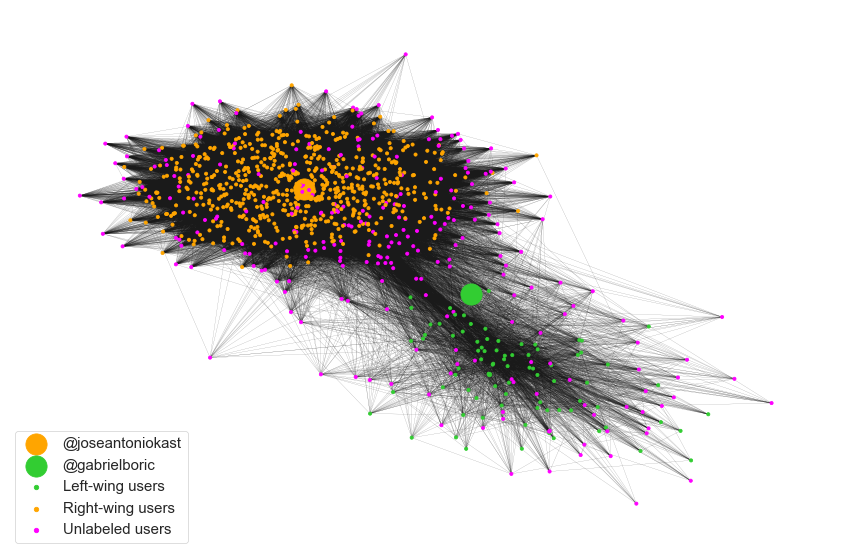

In [68]:
nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=['joseantoniokast'], label='@joseantoniokast', **{"node_size": 450, "node_color" : 'orange'}) #label='Media'
nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=['gabrielboric'], label='@gabrielboric', **{"node_size": 450, "node_color" : 'limegreen'}) #label='Media'

nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=['NachoOrtega'], label='Left-wing users', **{"node_size": 20 , "node_color" : 'limegreen'}) #label='Media'
nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=['Florencia_Pink'], label='Right-wing users', **{"node_size": 20 , "node_color" : 'orange'}) #label='Media'
nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=['AldoDuqueSantos'], label='Unlabeled users', **{"node_size": 20 , "node_color" : 'fuchsia'}) #label='Media'

plt.legend(loc="lower left", markerscale=1, scatterpoints=1, fontsize=15)

nx.draw(most_influencialG, pos_nodes, node_color=listofcolours, node_size=10, width=0.1) #, with_labels=True)

plt.show()

In [69]:
print('Runtime for Figure 3:', datetime.now() - start) #Print runtime

Runtime for Figure 3: 0:00:34.304909


# Figure 4

In [ ]:
communities = community.greedy_modularity_communities(G)

In [ ]:
modularity_dict = {} 
for i,c in enumerate(communities): # Loop through the list of communities
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # value: group 
nx.set_node_attributes(G, modularity_dict, 'modularity') #  add modularity information 

In [ ]:
modularity_df = pd.DataFrame(list(modularity_dict.items()),columns = ['User','modularity'])
modularity_df.head(2)

,User,modularity
0,PrensaDignidad,0
1,vivianaaurora,0


In [ ]:
top2=8000
subset_influencial_2=d.iloc[0:top2]
subset_influencial_2=pd.merge(subset_influencial_2,modularity_df,on='User')
subset_influencial_2.head(2)

,index,User,Retweet influence : Degree centrality,Label,modularity
0,5509,joseantoniokast,0.131623,Right,1
1,25866,AldoDuqueSantos,0.112336,Unlabeled,1


In [ ]:
colors = {'0':'limegreen', '1':'orange','2':'fuchsia', '3':'grey','10':'grey','11':'grey','19':'grey','24':'grey','41':'grey',} #,'3':'yellow' , '4':'purple', '10':'cyan', '11':'green'#assign colours to labels
subset_influencial_2['modularity']=subset_influencial_2['modularity'].astype(str)
subset_influencial_2['Colours'] = subset_influencial_2['modularity'].apply(lambda x: colors[x]) #apply colours to labels in df

In [ ]:
listofnodes=list(subset_influencial_2['User'])  #create a list of authors
most_influencialG=G_un.subgraph(listofnodes) #create a subgraph with undirected G and the nodes of interest
pos_nodes = nx.spring_layout(most_influencialG) #save the position of nodes (for colouring and legend)

In [ ]:
subset_influencial_2.set_index(subset_influencial_2['User'], inplace=True)
listofcolours=list(subset_influencial_2.loc[list(nx.spring_layout(most_influencialG).keys()), 'Colours'])

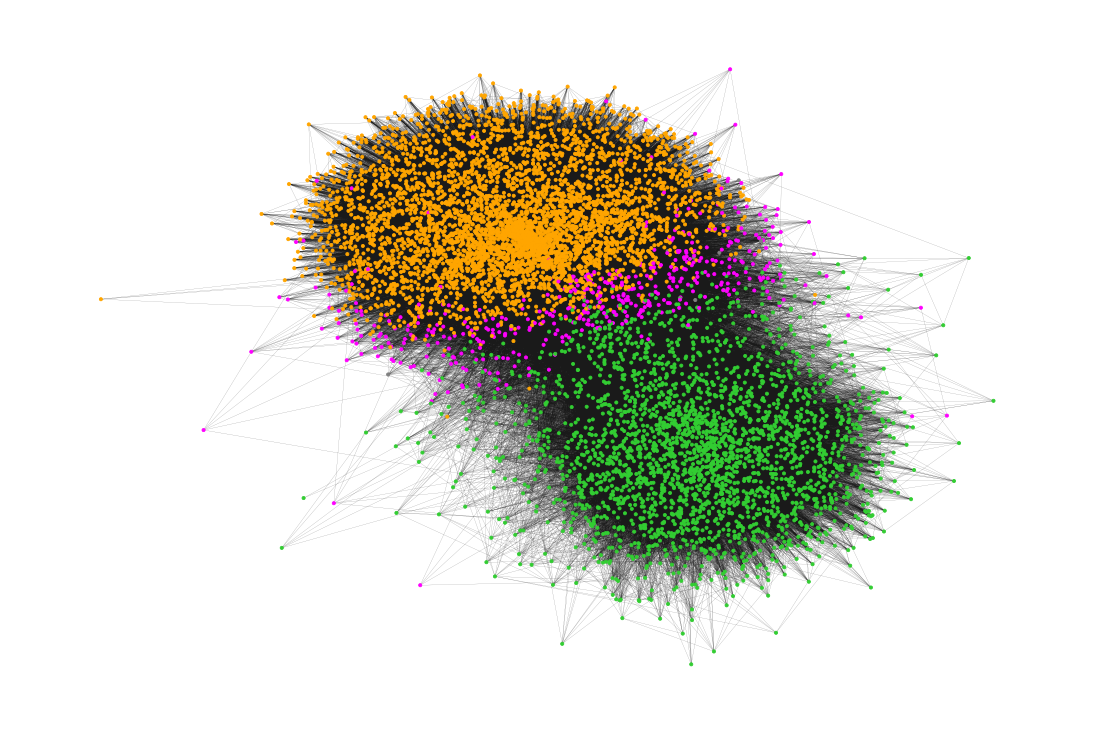

In [ ]:
nx.draw(most_influencialG,  pos_nodes, node_color=listofcolours, node_size=10, width=0.1) #, with_labels=True)
plt.show()

In [ ]:
#subset_influencial_2.set_index(subset_influencial_2['User'], inplace=True)
#listofnodes=class0+class1+class2+class3+class4+class5
class0=list(subset_influencial_2.index[subset_influencial_2['modularity']=='0'])
class1=list(subset_influencial_2.index[subset_influencial_2['modularity']=='1'])
class2=list(subset_influencial_2.index[subset_influencial_2['modularity']=='2'])
class3=list(subset_influencial_2.index[subset_influencial_2['modularity']=='3'])
class10=list(subset_influencial_2.index[subset_influencial_2['modularity']=='10'])
class11=list(subset_influencial_2.index[subset_influencial_2['modularity']=='11'])
class19=list(subset_influencial_2.index[subset_influencial_2['modularity']=='19'])
class24=list(subset_influencial_2.index[subset_influencial_2['modularity']=='24'])
class41=list(subset_influencial_2.index[subset_influencial_2['modularity']=='41'])
other=class3+class10+class11+class19+class24+class41                                      
                                   
#class4=list(subset_influencial_2.index[subset_influencial_2['modularity']=='4'])
#class5=list(subset_influencial_2.index[subset_influencial_2['modularity']=='5'])

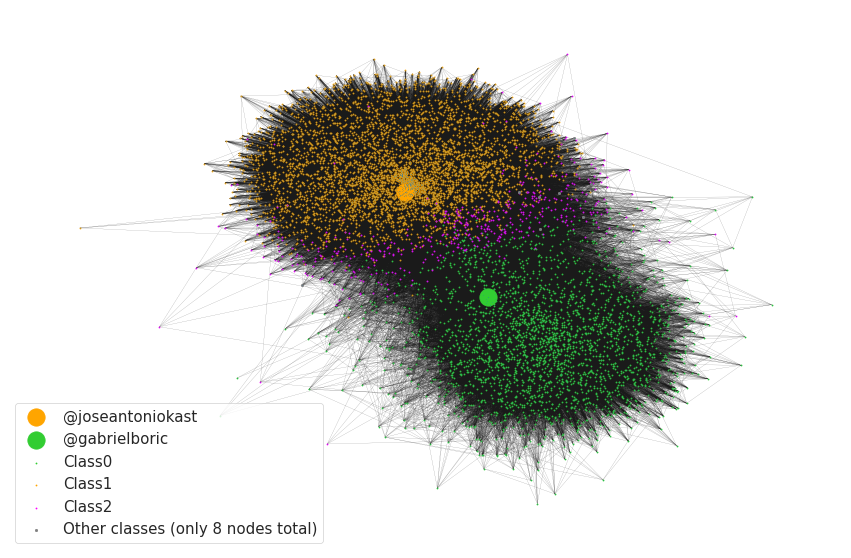

In [ ]:
nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=['joseantoniokast'], label='@joseantoniokast', **{"node_size": 300, "node_color" : 'orange'}) #label='Media'
nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=['gabrielboric'], label='@gabrielboric', **{"node_size": 300, "node_color" : 'limegreen'}) #label='Media'

nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=class0, label='Class0', **{"node_size": 1 , "node_color" : 'limegreen'}) #label='Media'
nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=class1, label='Class1', **{"node_size": 1 , "node_color" : 'orange'}) #label='Media'
nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=class2, label='Class2', **{"node_size": 1 , "node_color" : 'fuchsia'}) #label='Media'
nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=other, label='Other classes (only 8 nodes total)', **{"node_size": 5 , "node_color" : 'grey'}) #label='Media'
#nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=class4, label='Class4', **{"node_size": 20 , "node_color" : 'grey'}) #label='Media'
#nx.draw_networkx_nodes(most_influencialG, pos_nodes, nodelist=class5, label='Class5', **{"node_size": 20 , "node_color" : 'orange'}) #label='Media'

plt.legend(loc="lower left", markerscale=1, scatterpoints=1, fontsize=15)

nx.draw(most_influencialG, pos_nodes,  node_size=0.01, width=0.1) #, with_labels=True)

plt.show()

In [ ]:
analyse=subset_influencial_2.copy()

In [ ]:
analyse[(analyse.Label=='Right') & (analyse.modularity==0)]

,index,User,Retweet influence : Degree centrality,Label,modularity,Colours
User,,,,,,


In [ ]:
#0: left 
analyse[analyse.modularity=='0'].Label.value_counts()

Left         1693
Unlabeled    1046
Right          15
Name: Label, dtype: int64

In [ ]:
#1: right  
analyse[analyse.modularity=='1'].Label.value_counts()

Right        3398
Unlabeled    1354
Left            2
Name: Label, dtype: int64

In [ ]:
#2: unlabeled (medias, journalists)
analyse[analyse.modularity=='2'].Label.value_counts()

Unlabeled    395
Right         80
Left           9
Name: Label, dtype: int64